### machine learning demo using nys racetrack equine injury data

we will cover the following steps:
* pulling data from the ny open data catalogue
* brief exploratory data analysis
* data cleaning
* select and train a machine learning algorithm
* evaluate our results

#### step one: pulling and indexing data

In [1]:
from sodapy import Socrata
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sn
from sklearn.ensemble import RandomForestClassifier
from sklearn.grid_search import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import make_scorer
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

/Users/kaczmarek/anaconda2/lib/python2.7/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
/Users/kaczmarek/anaconda2/lib/python2.7/site-packages/sklearn/grid_search.py:42: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


In [2]:
# identify catalogue domain and datsaset endpoint
client = Socrata('data.ny.gov', None)
data = client.get('6zik-4gtg', limit = 5000, content_type = 'JSON')

# load the data as a data frame
df = pd.DataFrame.from_records(data)
df.head()

,death_or_injury,division,horse,incident_date,incident_description,incident_type,inv_location,jockey_driver,racing_type_description,track,trainer,weather_conditions,year
0,Injury,Harness,Stratus,2015-06-12T00:00:00.000,Stratus-Tr. Berube-DNF-vet exam revealed heart...,RACING INJURY,Vernon Downs,FERNAND A. PAQUET JR,Racing,Vernon Downs,ALEXANDRA S. HOWARD,Rain,2015
1,Equine Death,Thoroughbred,Sunshine Platter,2013-08-10T00:00:00.000,Sunshine Platter-Tr. Bireta-fx LF leg-fell-eut...,EQUINE DEATH,3/16 POLE,EMANUEL DE DIEGO,Racing,Finger Lakes Gaming & Racetrack,DONNA M. BIRETA,,2013
2,Equine Injury / Equine Death,Thoroughbred,No Cat Like That,2012-10-15T00:00:00.000,No Cat Like That-Tr. Chris Englehart-fx RH leg...,EQUINE DEATH,"Training Track, Finish Line",,Training,Belmont Park (NYRA),CHRISTOPHER J. ENGLEHART,Cloudy 55 to 60 : degrees F,2012
3,Steward's List,Thoroughbred,Tough Talk,2012-06-17T00:00:00.000,Tough Talk - Tr. Richard Dutrow - eased up - o...,STEWARDS/VETS LIST,"Main Track, 1/4 Pole",JUNIOR R. ALVARADO,Racing,Belmont Park (NYRA),RICHARD E. DUTROW JR,Clear 70 to 75 : degrees F,2012
4,Equine Death,Thoroughbred,The Lucky Dream,2014-07-10T00:00:00.000,The Lucky Dream-Tr. Michael Ferraro-collapsed ...,EQUINE DEATH,barn #7,,Non-Racing,Finger Lakes Gaming & Racetrack,MICHAEL S. FERRARO,,2014


#### step two: exploratory data analysis
what we will learn:
* how many incidents resulted in the death of the horse
* are there any time patterns we can discern 
* are some racetracks worse than others

In [3]:
# frequency counts of categories
pd.value_counts(df['incident_type'])

EQUINE DEATH                         1249
STEWARDS/VETS LIST                   1161
RACING INJURY                         311
FALL OF RIDER                         215
FALL OF HORSE                         116
ACCIDENT - ON TRACK                   111
ACCIDENT - TAGGED SULKY                56
ACCIDENT - IN STARTING GATE            22
ACCIDENT - DRIVER/JOCKEY               10
EQUINE DEATH - INFECTIOUS DISEASE      10
ON-TRACK ACCIDENT                       7
DRIVER/JOCKEY INJURED                   7
Name: incident_type, dtype: int64

In [4]:
# lets break down the frequency of deaths by racetrack
# first create a death indicator
df['incident_type'] = df['incident_type'].str.contains('DEATH')*1
# then build pivot table
pd.pivot_table(df, index = 'track', values = 'incident_type', aggfunc = 'sum')

,incident_type
track,
Aqueduct Racetrack (NYRA),207
Batavia Downs,18
Belmont Park (NYRA),388
Buffalo Raceway,32
Finger Lakes Gaming & Racetrack,367
Monticello Raceway & Mighty M Gaming,34
Saratoga Gaming & Raceway,31
Saratoga Racecourse (NYRA),125
Tioga Downs,13


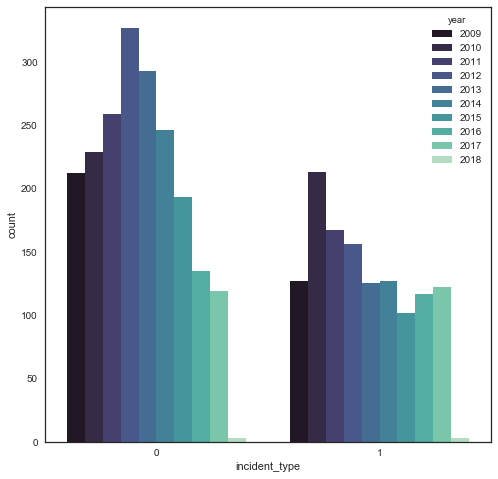

In [5]:
# let's visualize deaths per year
%matplotlib inline

sn.set(rc = {'figure.figsize': (8, 8)}, style = "white")
sn.countplot(x = 'incident_type', hue = 'year', data = df, palette = 'mako')

#### step three: data cleaning
what we will do:
* fill in missing values with a placeholder value
* check and remove any duplicate entries
* format timestamp in date field
* isolate weather condition from temperature

In [6]:
# remove any duplicates
df[df.duplicated(keep = False)]

,death_or_injury,division,horse,incident_date,incident_description,incident_type,inv_location,jockey_driver,racing_type_description,track,trainer,weather_conditions,year


In [7]:
# remove timestamp from date field and label season 1-4
df['incident_date'] = pd.to_datetime(df['incident_date'])
df['season'] = (df['incident_date'].dt.month%12 + 3)//3

In [8]:
# separate temperature from weather conditions
df['weather_conditions'] = map(lambda x: unicode(x).lower(), df['weather_conditions'])
df['temperature'] = df['weather_conditions'].str.extract(r'(\d+)').astype(float)
# give missing temps a value of avg. temp to change to integer type
df['temperature'] = df['temperature'].fillna(df['temperature'].mean())

/Users/kaczmarek/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:3: FutureWarning: currently extract(expand=None) means expand=False (return Index/Series/DataFrame) but in a future version of pandas this will be changed to expand=True (return DataFrame)
  This is separate from the ipykernel package so we can avoid doing imports until


In [9]:
# clean up some typos & standardize
df['weather_conditions'] = df['weather_conditions'].str.extract(r'(\b[a-z]+\b)')
replacements = {
    'overcast' : 'cloudy',
    'over' : 'cloudy',
    'cloudyy' : 'cloudy',
    'clody' : 'cloudy',
    'clouds' : 'cloudy',
    'couldy' : 'cloudy',
    'coudy' : 'cloudy'
}

df.loc[df['weather_conditions'].isin(replacements.keys()), 'weather_conditions'] = df['weather_conditions'].map(replacements)


/Users/kaczmarek/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:2: FutureWarning: currently extract(expand=None) means expand=False (return Index/Series/DataFrame) but in a future version of pandas this will be changed to expand=True (return DataFrame)
  


In [10]:
# lump together sparse values (value = less than 2% of total)
counts = df.weather_conditions.value_counts()
sparse_vals = counts.index[counts < df.shape[0] * 0.020]
df.loc[df['weather_conditions'].isin(sparse_vals), 'weather_conditions'] = "other"
print df.weather_conditions.value_counts()

clear     993
cloudy    513
other     399
partly    159
sunny     116
rain       66
Name: weather_conditions, dtype: int64


In [11]:
# fill in missing values
df.replace({' ' : np.nan, '' : np.nan, 'na' : np.nan, 'n/a' : np.nan, 'nan' : np.nan}, inplace = True)
df = df.fillna('missing')

In [12]:
# format location to lower case to match values and cateogrize sparse (<2%) values as 'other'
df['inv_location'] = map(lambda x: unicode(x).lower(), df['inv_location'])
counts = df['inv_location'].value_counts()
sparse_vals = counts.index[counts < df.shape[0] * 0.020]
df.loc[df['inv_location'].isin(sparse_vals), 'inv_location'] = 'other'
print df['inv_location'].value_counts()

other           2300
after finish     248
3/8 pole         120
1/4 pole         119
finger lakes     118
1/8 pole         108
missing          104
3/4 pole          85
stretch           73
Name: inv_location, dtype: int64


In [13]:
# examine jockey and trainer variables and group sparse entries (<1.5%)
jockey_counts = df['jockey_driver'].value_counts()
sparse_vals = jockey_counts.index[jockey_counts < df.shape[0] * 0.015]
df.loc[df['jockey_driver'].isin(sparse_vals), 'jockey_driver'] = 'other'
jockey_counts = df['jockey_driver'].value_counts()
trainer_counts = df['trainer'].value_counts()
sparse_vals_trainer = trainer_counts.index[trainer_counts < df.shape[0] * 0.015]
df.loc[df['trainer'].isin(sparse_vals_trainer), 'trainer'] = 'other'
print df['jockey_driver'].value_counts()
print df['trainer'].value_counts()

other                 1999
missing               1166
JUNIOR R. ALVARADO      58
IRAD ORTIZ JR           52
Name: jockey_driver, dtype: int64
other                       3112
missing                       58
CHRISTOPHER J. ENGLEHART      55
RODOLFO (RUDY) RODRIGUEZ      50
Name: trainer, dtype: int64


In [14]:
# drop unwanted/redundant features
df.drop(['death_or_injury', 'incident_description', 'horse', 'incident_date'], axis = 1, inplace = True)
list(df)

[u'division',
 u'incident_type',
 u'inv_location',
 u'jockey_driver',
 u'racing_type_description',
 u'track',
 u'trainer',
 u'weather_conditions',
 u'year',
 'season',
 'temperature']

In [15]:
# we need to one-hot encode our nonnumeric data for the random forests classifier
df_enc = pd.get_dummies(df)
df_enc.head()

,incident_type,season,temperature,division_Harness,division_Thoroughbred,inv_location_1/4 pole,inv_location_1/8 pole,inv_location_3/4 pole,inv_location_3/8 pole,inv_location_after finish,...,year_2009,year_2010,year_2011,year_2012,year_2013,year_2014,year_2015,year_2016,year_2017,year_2018
0,0,3,66.486833,1,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
1,1,3,66.486833,0,1,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
2,1,4,55.000000,0,1,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
3,0,3,70.000000,0,1,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
4,1,3,66.486833,0,1,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0


####  step four: building our random forests model
what we will do:
* split our data into training and testing sets using a non-Scikit method
* create our classifier
* evaluate our classifier using a confusion matrix
* try improving our model:
* split our data into train/test sets using the Scikit method
* create and optimize our classifier using cross validation
* evaluate our classifier using Scikit's classification report

In [16]:
# split into training and test sets
np.random.seed(100) # this is just to validate the results when other users run the code
df_enc['is_train'] = np.random.uniform(0, 1, len(df_enc)) <= .75
train, test = df_enc[df_enc['is_train'] == True], df_enc[df_enc['is_train'] == False]

print'Number of observations in the training data:', len(train)
print'Number of observations in the test data:', len(test)

Number of observations in the training data: 2486
Number of observations in the test data: 789


In [17]:
# create features and target variable
features = df_enc.columns[1:54]
y_target = pd.factorize(train['incident_type'])[0]
features

Index([                                    u'season',
                                      u'temperature',
                                 u'division_Harness',
                            u'division_Thoroughbred',
                            u'inv_location_1/4 pole',
                            u'inv_location_1/8 pole',
                            u'inv_location_3/4 pole',
                            u'inv_location_3/8 pole',
                        u'inv_location_after finish',
                        u'inv_location_finger lakes',
                             u'inv_location_missing',
                               u'inv_location_other',
                             u'inv_location_stretch',
                      u'jockey_driver_IRAD ORTIZ JR',
                 u'jockey_driver_JUNIOR R. ALVARADO',
                            u'jockey_driver_missing',
                              u'jockey_driver_other',
               u'racing_type_description_Non-Racing',
                   u'racing_

In [18]:
# train a basic classifier
clf = RandomForestClassifier(n_estimators = 100, random_state = 1)
clf.fit(train[features], y_target)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=1,
            oob_score=False, random_state=1, verbose=0, warm_start=False)

In [19]:
# apply to test set
y_pred = clf.predict(test[features])
# and view probabilities associated with each prediction
clf.predict_proba(test[features])[0:25]

array([[ 0.52      ,  0.48      ],
       [ 0.95      ,  0.05      ],
       [ 1.        ,  0.        ],
       [ 0.95857143,  0.04142857],
       [ 0.36283333,  0.63716667],
       [ 1.        ,  0.        ],
       [ 0.66066667,  0.33933333],
       [ 0.01      ,  0.99      ],
       [ 1.        ,  0.        ],
       [ 1.        ,  0.        ],
       [ 0.        ,  1.        ],
       [ 0.24833333,  0.75166667],
       [ 0.43722222,  0.56277778],
       [ 0.9025    ,  0.0975    ],
       [ 0.68      ,  0.32      ],
       [ 0.42083333,  0.57916667],
       [ 0.82202381,  0.17797619],
       [ 0.745     ,  0.255     ],
       [ 0.26200799,  0.73799201],
       [ 0.01      ,  0.99      ],
       [ 0.97      ,  0.03      ],
       [ 0.93269933,  0.06730067],
       [ 1.        ,  0.        ],
       [ 0.98666667,  0.01333333],
       [ 0.09      ,  0.91      ]])

In [20]:
# evaluation of classifier performance
# baseline: just guessing most common result of injury
pd.value_counts(df_enc['incident_type'])
df_enc.groupby('incident_type').size() * 100 / len(df_enc)

incident_type
0    61.557252
1    38.442748
dtype: float64

In [21]:
# overall accuracy
y_true = pd.factorize(test['incident_type'])[0]

def accuracy(y_pred, y_true):
    tp = [1 for k in range(len(y_pred)) if y_true[k] == y_pred[k]]
    tp = np.sum(tp)
    return tp/float(len(y_pred))

print'accuracy rate on test set:', accuracy(y_pred = y_pred, y_true = y_true)

accuracy rate on test set: 0.801013941698


In [22]:
# confusion matrix evaluation of classifier performance
pd.crosstab(test['incident_type'], y_pred, rownames = ['actual'], colnames = ['predicted'])

predicted,0,1
actual,,
0,427,60
1,97,205


In [23]:
# percentage correct
cross_tab = pd.crosstab(test['incident_type'], y_pred, rownames = ['actual'], colnames = ['predicted']).apply(lambda r: r/r.sum(), axis = 1)
print(cross_tab)

predicted         0         1
actual                       
0          0.876797  0.123203
1          0.321192  0.678808


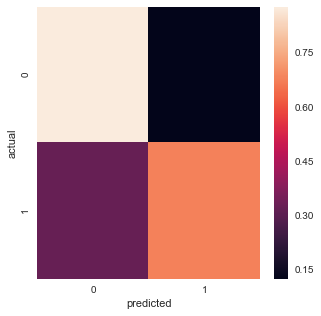

In [24]:
sn.set(rc = {'figure.figsize': (5, 5)}, style = 'white')
sn.heatmap(cross_tab)

In [25]:
# split into train/test using scikit function
y = df_enc['incident_type']
df_enc.drop(['incident_type', 'is_train'], axis = 1, inplace = True)
x_train, x_test, y_train, y_test = train_test_split(df_enc, y, random_state = 1)

In [27]:
# grid search for best parameters for random forest 
clfrf = RandomForestClassifier(n_estimators = 100, random_state = 1)
param = [{'max_depth': [None, 1, 5, 10],
         'min_samples_leaf': [1, 5, 10], 
         'min_samples_split': [2, 6, 11],}
    ]

scoring = make_scorer(accuracy_score)
gs = GridSearchCV(estimator = clfrf, param_grid = param, scoring = scoring, cv = 10)
gs = gs.fit(x_train, y_train)
bestparam = gs.best_params_
print'best parameters:', bestparam

best parameters: {'min_samples_split': 11, 'max_depth': None, 'min_samples_leaf': 5}


In [28]:
# train a second classifier using the best parameters
clf_2 = RandomForestClassifier(n_estimators = 100, min_samples_split = 11, max_depth = None, min_samples_leaf = 5)
clf_2.fit(x_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=5, min_samples_split=11,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [29]:
# evaluate the second classifier using scikit's accuracy scoring
y_pred2 = clf_2.predict(x_test)
accuracy_score(y_test, y_pred2)

0.80586080586080588

In [30]:
# confusion matrix
conf = pd.DataFrame(
    confusion_matrix(y_test, y_pred2),
    columns = ['predicted injured', 'predicted death'],
    index = ['actual injured', 'actual death']
)
conf
conf.apply(lambda r: r/r.sum(), axis = 1)

,predicted injured,predicted death
actual injured,0.922000,0.078000
actual death,0.376176,0.623824


In [31]:
# overall metrics report (scale: 0-1, 1 is best)
# how precisely does the model avoid false positves (precision)?
# how successfully does the model find all the positive samples (recall)?
print(classification_report(y_test, y_pred2))

             precision    recall  f1-score   support

          0       0.79      0.92      0.85       500
          1       0.84      0.62      0.71       319

avg / total       0.81      0.81      0.80       819

